In [1]:
!pip install kaggle

In [2]:
!kaggle datasets download -d muhammadrizkyperdana/lungs-dataset

Dataset URL: https://www.kaggle.com/datasets/muhammadrizkyperdana/lungs-dataset
License(s): unknown
100% 1.04G/1.04G [00:38<00:00, 39.4MB/s]
100% 1.04G/1.04G [00:38<00:00, 28.9MB/s]


In [3]:
!unzip lungs-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Lungs Dataset/NORMAL/1 (41).png  
  inflating: Lungs Dataset/NORMAL/1 (42).png  
  inflating: Lungs Dataset/NORMAL/1 (43).png  
  inflating: Lungs Dataset/NORMAL/1 (44).png  
  inflating: Lungs Dataset/NORMAL/1 (45).png  
  inflating: Lungs Dataset/NORMAL/1 (46).png  
  inflating: Lungs Dataset/NORMAL/1 (47).png  
  inflating: Lungs Dataset/NORMAL/1 (48).png  
  inflating: Lungs Dataset/NORMAL/1 (49).png  
  inflating: Lungs Dataset/NORMAL/1 (5).png  
  inflating: Lungs Dataset/NORMAL/1 (50).png  
  inflating: Lungs Dataset/NORMAL/1 (51).png  
  inflating: Lungs Dataset/NORMAL/1 (52).png  
  inflating: Lungs Dataset/NORMAL/1 (53).png  
  inflating: Lungs Dataset/NORMAL/1 (54).png  
  inflating: Lungs Dataset/NORMAL/1 (55).png  
  inflating: Lungs Dataset/NORMAL/1 (56).png  
  inflating: Lungs Dataset/NORMAL/1 (57).png  
  inflating: Lungs Dataset/NORMAL/1 (58).png  
  inflating: Lungs Dataset/NORMAL/1 (59).png  
  inflatin

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

data_dir = 'Lungs Dataset'
output_dir = 'Dataset'

train_ratio = 0.8
test_ratio = 1-train_ratio

os.makedirs(output_dir, exist_ok=True)

class_counts = {}

# Split each class in the directories
for class_name in os.listdir(data_dir):

    class_dir = os.path.join(data_dir, class_name)

    if os.path.isdir(class_dir):
      # List info on all images in the current class folder
        images = os.listdir(class_dir)
        class_counts[class_name] = len(images)

        # split into train and test datasets
        train_images, test_images = train_test_split(images, test_size=1-train_ratio, random_state=42)

        # Create output folders for train and test
        train_folder = os.path.join(output_dir, 'train', class_name)
        test_folder = os.path.join(output_dir, 'test', class_name)

        os.makedirs(train_folder, exist_ok=True)
        os.makedirs(test_folder, exist_ok=True)

        for image in train_images:
            shutil.copy(os.path.join(class_dir, image), train_folder)
        for image in test_images:
            shutil.copy(os.path.join(class_dir, image), test_folder)

# Print information of the split
print('Class Counts:')
for class_name, count in class_counts.items():
    print(f'{class_name}: {count} images')
print('Data split into train and test datasets')

Class Counts:
NORMAL: 2233 images
PNEUMONIA: 2102 images
TUBERCOLOSIS: 700 images
COVID19: 2091 images
Data split into train and test datasets


In [5]:
def info_on_dataset(path):
  '''Gives all the information on how datasets are stored'''
  for dir_path, dir_names, file_names in os.walk(path):
    print(f"There are {len(dir_names)} directories and {len(file_names)} images in '{dir_path}'")

In [6]:
info_on_dataset(output_dir)

There are 2 directories and 0 images in 'Dataset'
There are 4 directories and 0 images in 'Dataset/train'
There are 0 directories and 1786 images in 'Dataset/train/NORMAL'
There are 0 directories and 1681 images in 'Dataset/train/PNEUMONIA'
There are 0 directories and 560 images in 'Dataset/train/TUBERCOLOSIS'
There are 0 directories and 1672 images in 'Dataset/train/COVID19'
There are 4 directories and 0 images in 'Dataset/test'
There are 0 directories and 447 images in 'Dataset/test/NORMAL'
There are 0 directories and 421 images in 'Dataset/test/PNEUMONIA'
There are 0 directories and 140 images in 'Dataset/test/TUBERCOLOSIS'
There are 0 directories and 419 images in 'Dataset/test/COVID19'


Path: Dataset/train/PNEUMONIA/6 (11).png
Class: PNEUMONIA
Size: (512, 512)


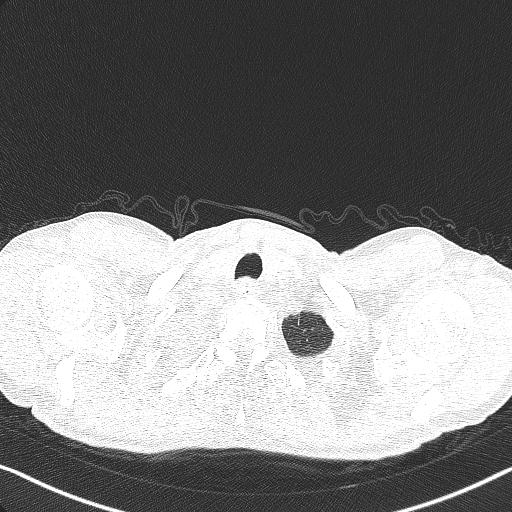

In [7]:
import random
from pathlib import Path
from PIL import Image

data_path = Path(output_dir)

# get all the image paths
image_paths = list(data_path.glob('*/*/*.png')) + list(data_path.glob('*/*/*.jpg'))

# pick random image and print its info
random_image = random.choice(image_paths)
random_image_class = random_image.parent.stem
image = Image.open(random_image)
print(f'Path: {random_image}')
print(f'Class: {random_image_class}')
print(f'Size: {image.size}')
image

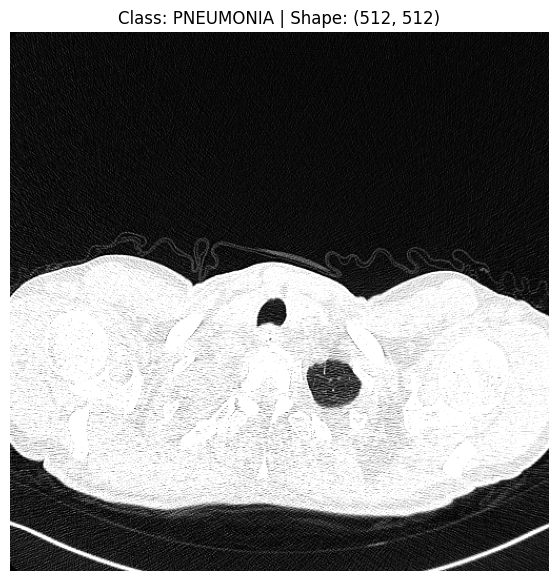

In [8]:
import numpy as np
import matplotlib.pyplot as plt

image_array = np.asarray(image)
plt.figure(figsize=(10, 7))
plt.imshow(image_array, cmap='gray')
plt.title(f'Class: {random_image_class} | Shape: {image_array.shape}') # height,width,color_channels = 0 -> grayscale
plt.axis('off')
plt.show()

In [9]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

IMAGE_SIZE = (256, 256)

class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir  # Path to image directory
        self.transform = transform  # Optional transform to be applied on a sample

        # Getting image files and corresponding class labels
        self.image_paths = []
        self.labels = []

        class_names = sorted(os.listdir(image_dir))
        self.class_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        # Loop through each class folder and get image paths and labels
        for class_name in class_names:
            class_folder = os.path.join(image_dir, class_name)
            if os.path.isdir(class_folder):
                for img_name in os.listdir(class_folder):
                    self.image_paths.append(os.path.join(class_folder, img_name))
                    self.labels.append(self.class_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Open image using PIL
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        image = image.resize(IMAGE_SIZE)  # Resize image to fixed size

        # Convert image to numpy array and normalize
        image_array = np.asarray(image) / 255.0

        # Add the channel dimension to make it (1, height, width)
        image_array = np.expand_dims(image_array, axis=0)

        # Convert numpy array to torch tensor
        image_tensor = torch.tensor(image_array, dtype=torch.float32)

        # Apply transformations
        if self.transform:
            image_tensor = self.transform(image_tensor)

        # Return the image and label
        return image_tensor, label

In [10]:
train_dir = 'Dataset/train'
test_dir = 'Dataset/test'

# Create dataset and dataloader (with lazy loading)
train_dataset = CustomDataset(image_dir=train_dir)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_dataset = CustomDataset(image_dir=test_dir)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

print(train_dataloader, test_dataloader)
print(len(train_dataloader), len(test_dataloader))

<torch.utils.data.dataloader.DataLoader object at 0x7ab6c4335060> <torch.utils.data.dataloader.DataLoader object at 0x7ab6c4335180>
357 90


In [11]:
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions = None):
  plt.figure(figsize=(8,5))
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training Data')
  plt.scatter(test_data, test_labels, c='g', s=4, label='Testing Data')

  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  plt.legend(prop={'size':14})

def accuracy_fn(y_true, y_pred):
  _, predicted = torch.max(y_pred, 1)
  correct = torch.eq(y_true, predicted).sum().item()
  acc = (correct / len(y_true)) * 100
  return acc

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
import torch.nn as nn
import torch.optim as optim
import torch

def train_step(model: nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn, device: torch.device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)
        running_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        acc = accuracy_fn(y_true=y, y_pred=y_pred)
        running_acc += acc

    # Average loss and accuracy
    avg_loss = running_loss / len(data_loader)
    avg_acc = running_acc / len(data_loader)

    print(f"Train Loss: {avg_loss:.5f} | Train Acc: {avg_acc:.2f}%")

def test_step(model: nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: nn.Module, accuracy_fn, device: torch.device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():  # Disable gradient computation during testing
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)

            # Calculate loss
            loss = loss_fn(y_pred, y)
            # Calculate accuracy
            acc = accuracy_fn(y_true=y, y_pred=y_pred)

            # Update running totals
            running_loss += loss.item()
            running_acc += acc

    # Average loss and accuracy
    avg_loss = running_loss / len(data_loader)
    avg_acc = running_acc / len(data_loader)

    print(f"Test Loss: {avg_loss:.5f} | Test Acc: {avg_acc:.2f}%")

In [22]:
def eval_model(model: nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: nn.Module, accuracy_fn):
  loss, acc = 0, 0
  model.eval()
  model = model.to(device)
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred)
    loss /= len(data_loader)
    acc /= len(data_loader)
  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

In [65]:
class Model(nn.Module):
    '''
    Two convolutional blocks with ReLU activations
    A fully connected layer after flattening the output
    Softmax to classify the output
    '''
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*64*64,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        x = nn.functional.softmax(x, dim=1)
        return x

In [16]:
class_names = sorted(os.listdir(train_dir))
class_names

['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCOLOSIS']

In [17]:
model = Model(input_shape=1, hidden_units=64, output_shape=len(class_names)).to(device)
model

Model(
  (block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=262144, out_features=4, bias=True)
  )
)

In [18]:
scaler = torch.cuda.amp.GradScaler()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

<ipython-input-18-b31ed868c0cc>:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [19]:
epochs = 3
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n---------")
  train_step(model=model, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn, device=device)
  test_step(model=model, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)

Epoch: 0
---------
Train Loss: 0.84704 | Train Acc: 89.81%
Test Loss: 0.75629 | Test Acc: 98.89%
Epoch: 1
---------
Train Loss: 0.75263 | Train Acc: 99.14%
Test Loss: 0.75506 | Test Acc: 98.80%
Epoch: 2
---------
Train Loss: 0.75526 | Train Acc: 98.84%
Test Loss: 0.75204 | Test Acc: 99.17%


In [23]:
results = eval_model(model=model, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
results

{'model_name': 'Model',
 'model_loss': 0.7520341873168945,
 'model_acc': 99.16666666666667}

In [63]:
class ModelV1(nn.Module):
    '''
    Two convolutional blocks with Batch Normalization and ReLU activations
    Uses Global Average Pooling (GAP) to reduce spatial dimensions
    A fully connected layer outputs class probabilities
    '''
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units*2),
            nn.ReLU(),
            nn.Conv2d(hidden_units*2, hidden_units*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units*2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully Connected Layer (Linear)
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Flatten the output from Global Average Pooling
            nn.Linear(hidden_units*2, output_shape)  # Adjust for the number of channels
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.global_avg_pool(x)
        # print(x.shape)
        x = self.classifier(x)
        x = nn.functional.softmax(x, dim=1)
        return x

In [37]:
model1 = ModelV1(input_shape=1, hidden_units=64, output_shape=len(class_names)).to(device)
model1

ModelV1(
  (block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (global_avg_pool): AdaptiveAvgPool2d(ou

In [38]:
loss_fn1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4, weight_decay=1e-5)

In [39]:
epochs = 3
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n---------")
  train_step(model=model1, data_loader=train_dataloader, loss_fn=loss_fn1, optimizer=optimizer1, accuracy_fn=accuracy_fn, device=device)
  test_step(model=model1, data_loader=test_dataloader, loss_fn=loss_fn1, accuracy_fn=accuracy_fn, device=device)

Epoch: 0
---------
Train Loss: 1.04917 | Train Acc: 76.76%
Test Loss: 0.93382 | Test Acc: 89.98%
Epoch: 1
---------
Train Loss: 0.92132 | Train Acc: 90.53%
Test Loss: 0.88572 | Test Acc: 90.90%
Epoch: 2
---------
Train Loss: 0.87795 | Train Acc: 92.47%
Test Loss: 0.86208 | Test Acc: 93.82%


In [40]:
results1 = eval_model(model=model1, data_loader=test_dataloader, loss_fn=loss_fn1, accuracy_fn=accuracy_fn)
results1

{'model_name': 'ModelV1',
 'model_loss': 0.8619155287742615,
 'model_acc': 93.81944444444444}

###Results

It is noticeable that model works better than the second one because of a smaller dataset and easy to design tasks

In [41]:
import pandas as pd
compare_results = pd.DataFrame([results, results1])
compare_results

,model_name,model_loss,model_acc
0,Model,0.752034,99.166667
1,ModelV1,0.861916,93.819444


Text(0, 0.5, 'model')

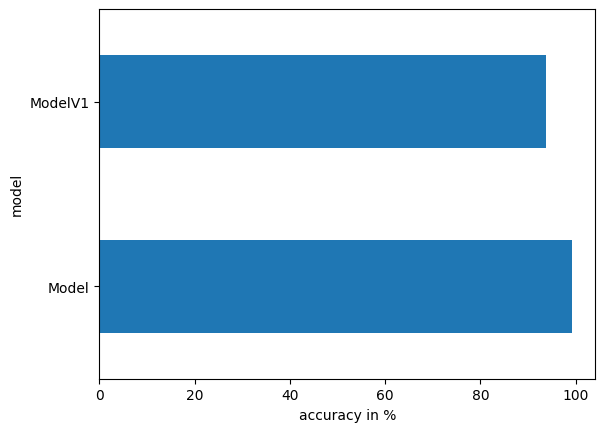

In [43]:
compare_results.set_index('model_name')['model_acc'].plot(kind='barh')
plt.xlabel('accuracy in %')
plt.ylabel('model')

In [44]:
def make_predictions(model: nn.Module, data: list, device: torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())
  return torch.stack(pred_probs)

In [53]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):
  test_samples.append(sample)
  test_labels.append(label)

In [54]:
pred_probs = make_predictions(model=model, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

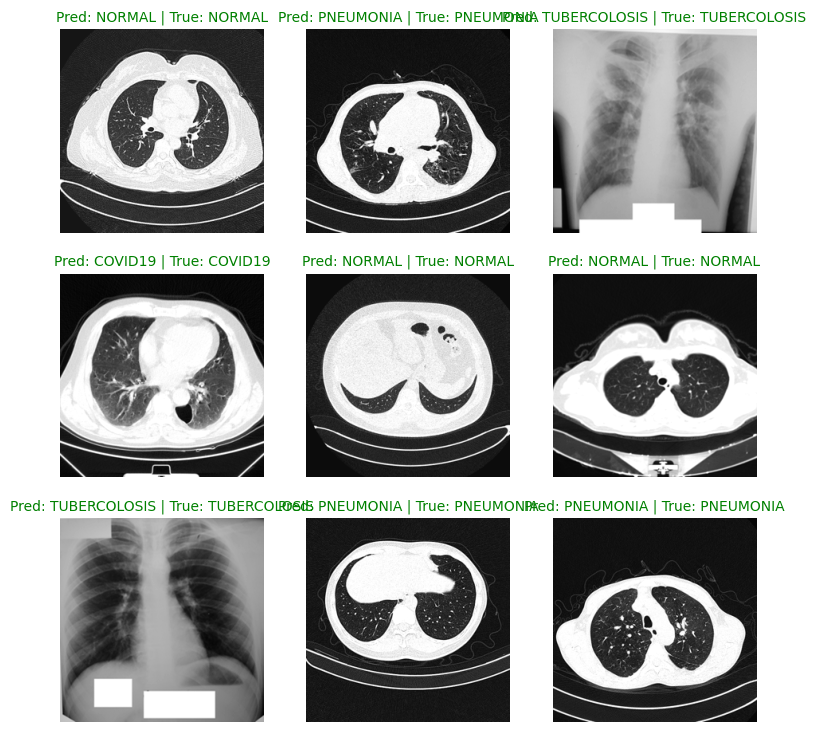

In [55]:
# Randomly plotting 9 figures with true and predicted label
plt.figure(figsize=(9, 9))
nrows, ncols = 3, 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_names[pred_classes[i]]
  true_label = class_names[test_labels[i]]
  title_text = f"Pred: {pred_label} | True: {true_label}"
  if pred_label == true_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")
  plt.axis("off")

In [59]:
y_preds = []
targets = []
model.eval()
with torch.inference_mode():
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    y_logit = model(X)
    y_pred = torch.softmax(y_logit, dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())
    targets.append(y.cpu())
y_preds = torch.cat(y_preds)
targets = torch.cat(targets)

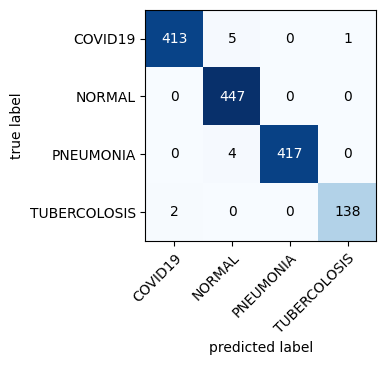

In [62]:
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(y_preds, targets)

# Plotting the confusion matrix for the model
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), figsize=(5, 3), class_names=class_names)